In [1]:
!pip install shap

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("diabetes_prediction_dataset.csv")
df = df[:5000]
df.head()

X = df[['age','hypertension','heart_disease','bmi','HbA1c_level','blood_glucose_level']]
y = df['diabetes']

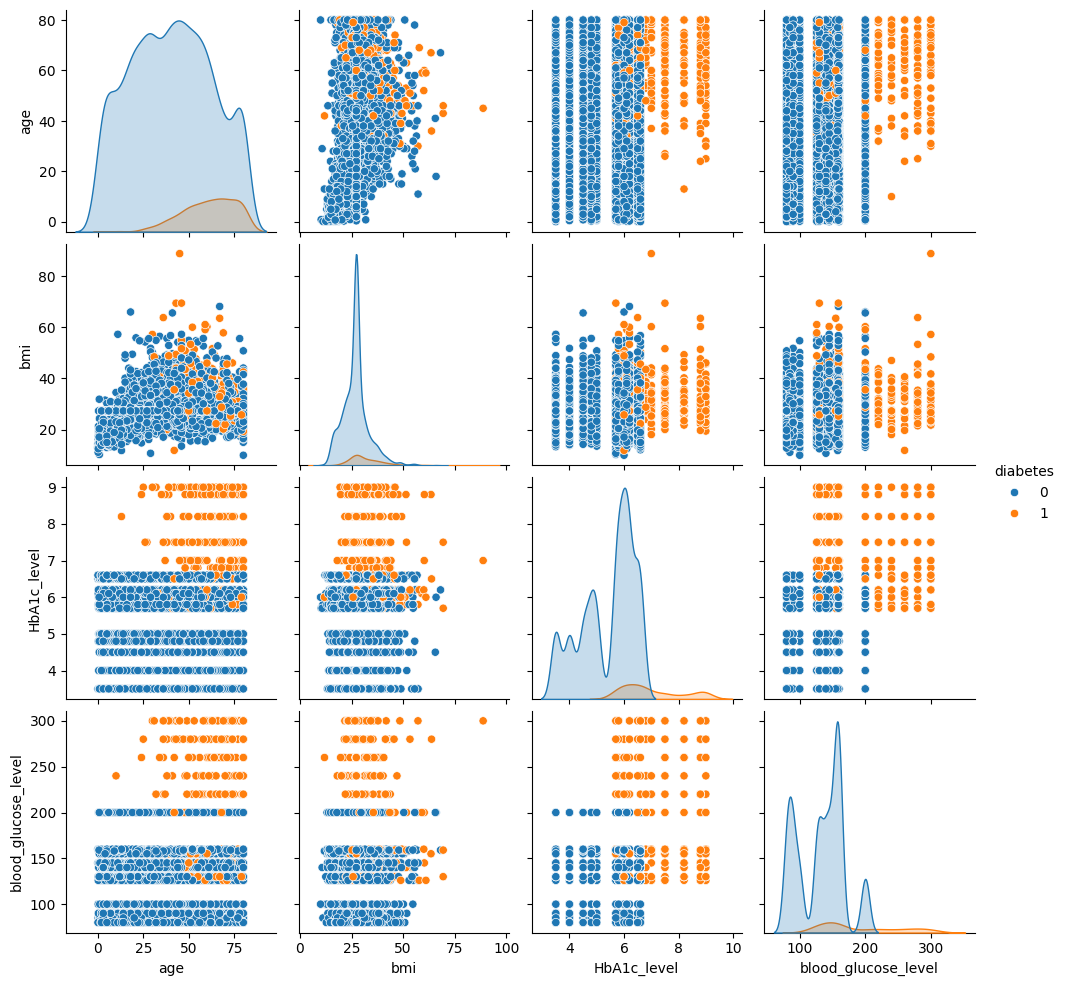

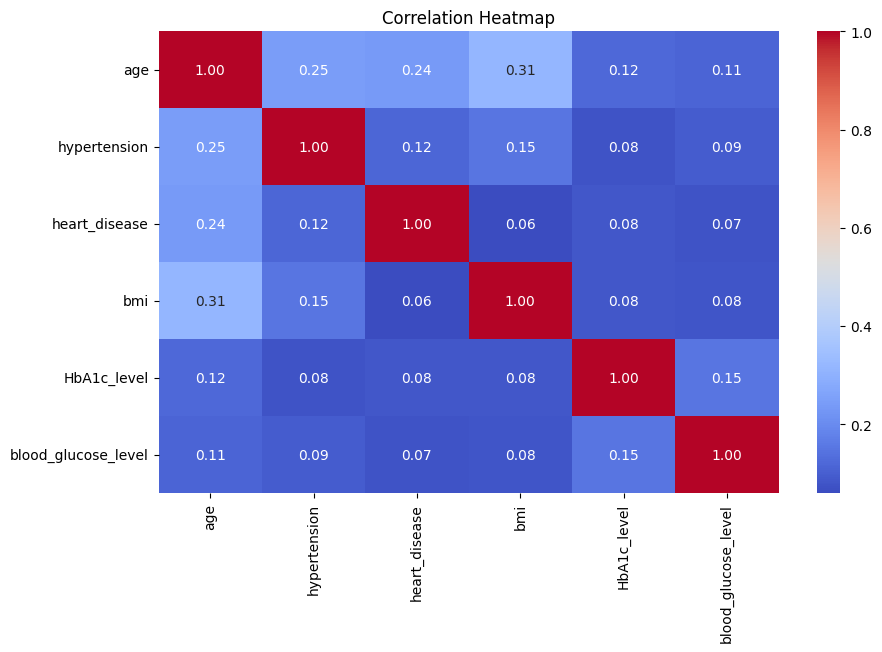

In [3]:
sns.pairplot(df, vars=['age', 'bmi', 'HbA1c_level', 'blood_glucose_level'], hue='diabetes', diag_kind='kde')
plt.show()

plt.figure(figsize=(10, 6))
sns.heatmap(X.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

In [4]:
import xgboost
from IPython.display import display
import shap
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# bst = xgboost.train({"learning_rate": 0.01}, xgboost.DMatrix(X_train, label=y_train), 100)

In [5]:
# Enable logging of evaluation metrics
params = {
    "objective": "binary:logistic",
    "learning_rate": 0.01,
    "eval_metric": "logloss"
}
eval_set = [(xgboost.DMatrix(X_train, label=y_train), "train"), (xgboost.DMatrix(X_test, label=y_test), "test")]

results = {}
bst = xgboost.train(params, xgboost.DMatrix(X_train, label=y_train), 100, evals=eval_set, evals_result=results, verbose_eval=10)

[0]	train-logloss:0.31716	test-logloss:0.30897
[10]	train-logloss:0.28147	test-logloss:0.27676
[20]	train-logloss:0.25471	test-logloss:0.25244
[30]	train-logloss:0.23326	test-logloss:0.23295
[40]	train-logloss:0.21546	test-logloss:0.21676
[50]	train-logloss:0.20038	test-logloss:0.20302
[60]	train-logloss:0.18726	test-logloss:0.19117
[70]	train-logloss:0.17587	test-logloss:0.18089
[80]	train-logloss:0.16580	test-logloss:0.17191
[90]	train-logloss:0.15706	test-logloss:0.16399
[99]	train-logloss:0.15008	test-logloss:0.15764


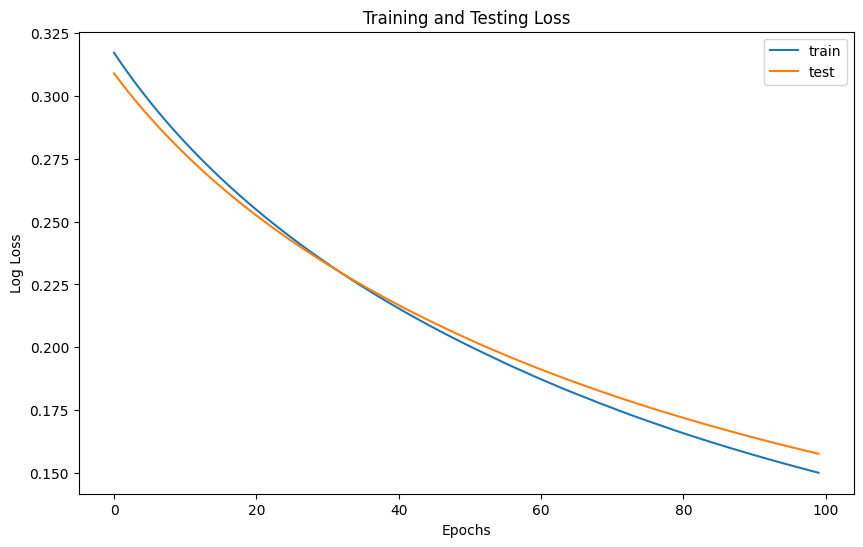

In [6]:
# Plotting loss curve
plt.figure(figsize=(10, 6))
for dataset in results:
    plt.plot(results[dataset]['logloss'], label=dataset)
plt.title("Training and Testing Loss")
plt.xlabel("Epochs")
plt.ylabel("Log Loss")
plt.legend()
plt.show()

In [7]:
y_pred_proba = bst.predict(xgboost.DMatrix(X_test))
y_pred = [1 if p > 0.5 else 0 for p in y_pred_proba]

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy of XGBoost model:", accuracy)

Accuracy of XGBoost model: 0.968


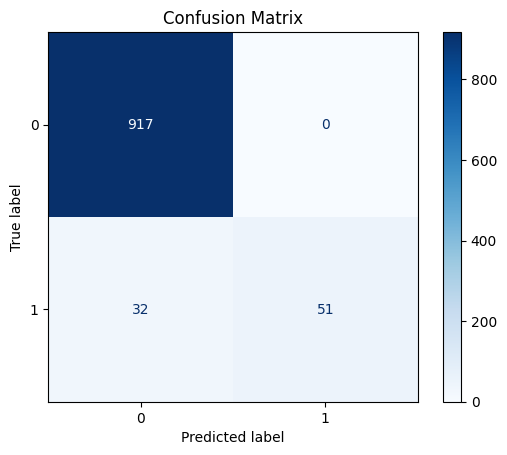

In [8]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=[0, 1])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

In [9]:
# Classification Report
class_report = classification_report(y_test, y_pred, target_names=["Non-Diabetic", "Diabetic"])
print("Classification Report:\n", class_report)

Classification Report:
               precision    recall  f1-score   support

Non-Diabetic       0.97      1.00      0.98       917
    Diabetic       1.00      0.61      0.76        83

    accuracy                           0.97      1000
   macro avg       0.98      0.81      0.87      1000
weighted avg       0.97      0.97      0.96      1000



### **SHAP (XAI)**

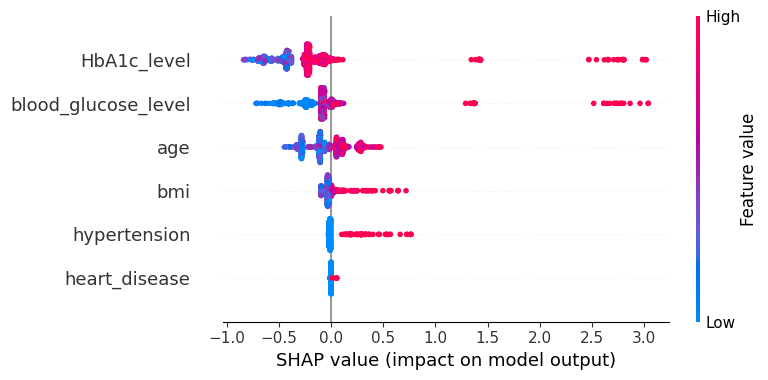

In [10]:
explainer = shap.TreeExplainer(bst)
explanation = explainer(X)
shap.initjs()
shap.plots.force(explanation[0])

shap_values = shap.TreeExplainer(bst).shap_values(X_test)
shap.summary_plot(shap_values, X_test)